In [100]:
# imports and installs
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.optim import SGD, Adam, ASGD

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import monai
from monai.transforms import (ScaleIntensityRange, Compose, AddChannel, RandSpatialCrop, ToTensor, 
                            RandAxisFlip, Activations, AsDiscrete, Resize, RandRotate, RandFlip, EnsureType,
                             KeepLargestConnectedComponent, CenterSpatialCrop)
from monai.metrics import DiceMetric, HausdorffDistanceMetric, PSNRMetric, SSIMMetric
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, FocalLoss, GeneralizedDiceLoss, DiceCELoss, DiceFocalLoss
from monai.networks.nets import UNet, VNet, UNETR, SwinUNETR, AttentionUnet, AutoEncoder
from monai.data import decollate_batch, ImageDataset
from monai.utils import set_determinism
import os
import wandb
from time import time
from einops import rearrange
from einops.layers.torch import Rearrange
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR
from random import sample

torch.manual_seed(2000)
set_determinism(seed=2000)

wandb_log = True

!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [101]:
def get_img_label_folds(img_paths, label_paths):
    
    fold = list(range(0,len(img_paths)))
    fold = sample(fold, k=len(fold))
    fold_imgs = [img_paths[i] for i in fold]
    fold_labels = [label_paths[i] for i in fold]
    return fold_imgs, fold_labels

# Transforms for images & labels
train_roi_size = 160
resize_dim = 256
transforms_map = {
        "train_img_transform" : [
            AddChannel(),
            # Resize(spatial_size=(resize_dim, resize_dim, -1)),
            # CenterSpatialCrop([train_roi_size, train_roi_size, -1]),
            RandSpatialCrop(roi_size= train_roi_size, random_center = True, random_size=False),
            ToTensor()
            ],
        "train_label_transform" : [
            AddChannel(),
            # Resize(spatial_size=(resize_dim, resize_dim, -1)),
            # CenterSpatialCrop([train_roi_size, train_roi_size, -1]),
            # RandSpatialCrop(roi_size= train_roi_size, random_center = True, random_size=False),
            AsDiscrete(threshold=0.5),
            ToTensor()
            ],
        "test_img_transform" : [
            AddChannel(),
            # Resize(spatial_size=(resize_dim, resize_dim, -1)),
            CenterSpatialCrop([train_roi_size, train_roi_size, -1]),
            ToTensor()
            ],
        "test_label_transform" : [
            AddChannel(),
            # Resize(spatial_size=(resize_dim, resize_dim, -1)),
            # CenterSpatialCrop([train_roi_size, train_roi_size, -1]),
            AsDiscrete(threshold=0.5),
            ToTensor()
            ],
    }

# 1. Image & Label paths

dataset_map = {
        "promise12" : {
            "data_dir" : "../datasets/promise12prostatealigned/",
            "test_size" : 0.1,
            'test' :  {'images' : [], 'labels' : []},
            'train' :  {'images' : [], 'labels' : []}
            
            },
        "decathlon" : {
            "data_dir" : "../datasets/decathlonprostatealigned/",
            "test_size" : 0.2,
            'test' :  {'images' : [], 'labels' : []},
            'train' :  {'images' : [], 'labels' : []}
            },
        "isbi" : {
            "data_dir" : "../datasets/isbiprostatealigned/",
            "test_size" : 0.2,
            'test' :  {'images' : [], 'labels' : []},
            'train' :  {'images' : [], 'labels' : []}
            },
        "prostate158" : {
            "data_dir" : "../datasets/prostate158aligned/",
            "test_size" : 0.2,
            'test' :  {'images' : [], 'labels' : []},
            'train' :  {'images' : [], 'labels' : []}
            }
        
    }


for dataset in dataset_map:
    print(f"------------{dataset}------------")
    data_dir = dataset_map[dataset]['data_dir']

    img_paths = glob(data_dir + "imagesTr/*.nii")
    label_paths = glob(data_dir + "labelsTr/*.nii")
    img_paths.sort()
    label_paths.sort()
    
    # 2. Folds

    images_fold, labels_fold  = get_img_label_folds(img_paths, label_paths)
    
    print("Number of images: {}".format(len(images_fold)))
    print("Number of labels: {}".format(len(labels_fold)))
    
    # Get train and test sets
    # 3. Split into train - test
    train_idx = int(len(images_fold) * (1 - dataset_map[dataset]['test_size']))
    
    # Store train & test sets 
    
    dataset_map[dataset]['train']['images'] = images_fold[:train_idx]
    dataset_map[dataset]['train']['labels'] = labels_fold[:train_idx]
    
    dataset_map[dataset]['test']['images'] = images_fold[train_idx:]
    dataset_map[dataset]['test']['labels'] = labels_fold[train_idx:]

------------promise12------------
Number of images: 50
Number of labels: 50
------------decathlon------------
Number of images: 32
Number of labels: 32
------------isbi------------
Number of images: 79
Number of labels: 79
------------prostate158------------
Number of images: 139
Number of labels: 139


In [102]:
batch_size = 1
def get_dataloader(img_paths : list, train : bool):
    
    if train:
        ttset = "train"
    else:
        ttset = "test"
        
    dataset = ImageDataset(img_paths,
                            transform=Compose(transforms_map[f'{ttset}_img_transform']))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return  dataloader

In [103]:
dataloaders_map = {}

for dataset in dataset_map:
    print(f"------------{dataset}------------")
    dataloaders_map[dataset] = {}
    for ttset in ['train', 'test']:
        if ttset == 'train':
            train = True
        else:
            train = False
        
        dataloaders_map[dataset][ttset] = get_dataloader(img_paths = dataset_map[dataset][ttset]['images'],
                                                          train = train)
        
        print(f"""No of samples in {dataset}-{ttset} : {len(dataloaders_map[dataset][ttset])}""")

# 7. That's it

------------promise12------------
No of samples in promise12-train : 45
No of samples in promise12-test : 5
------------decathlon------------
No of samples in decathlon-train : 25
No of samples in decathlon-test : 7
------------isbi------------
No of samples in isbi-train : 63
No of samples in isbi-test : 16
------------prostate158------------
No of samples in prostate158-train : 111
No of samples in prostate158-test : 28


In [104]:
all_train_img_paths = []
for dataset_name in dataset_map.keys():
    all_train_img_paths.extend(dataset_map[dataset_name]['train']['images'])
    
multi_domain_train_loader = get_dataloader(
    img_paths = all_train_img_paths, train=True
)


Image shape : torch.Size([28, 1, 160, 160])


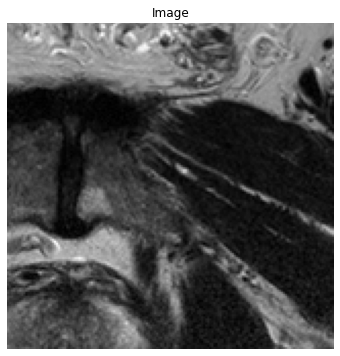

In [105]:
# ----------------------------Get dataloaders--------------------------
imgs = next(iter(dataloaders_map['promise12']['train']))
imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')
print(f"\nImage shape : {imgs.shape}")

img_no = 10
plt.figure(figsize=(6*3,6*1))
# plt.subplot(1,3,1)
plt.imshow(imgs[img_no,0], cmap='gray')
plt.axis('off')
plt.title('Image')
plt.show()

In [106]:
# print(f"\nTraining samples : {len(multi_domain_train_loader)}")

# # # -----------------------Slices-----------------------------

# plt.figure(figsize = (1*7, 1*7))

# # Spatial dims
# spdims = [img.shape[3] for img in multi_domain_train_loader]
# np.unique(spdims)
# print({x:spdims.count(x) for x in np.unique(spdims)})

# # # plt.subplot(1,2,1)
# plt.hist(spdims)
# plt.xlabel('Slices')
# plt.ylabel('Count')
# plt.title('Training Set')

# # # slices = [label.shape[4] for _, label in test_loader]
# # # plt.subplot(1,2,2)
# # # plt.hist(slices, )
# # # plt.xlabel('Slices')
# # # plt.ylabel('Count')
# # # plt.title('Testing set')

# # plt.suptitle('Slices in Training & Testing Sets')
# plt.show()

In [107]:
class ClipToRange(monai.transforms.Transform):
    def __call__(self, x : torch.Tensor):
        return torch.clamp(x, min=0.0, max=1.0)

In [108]:
# ----------------------------Train Config-----------------------------------------
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

model = AutoEncoder(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(4, 8, 16, 32, 64),
    strides=(2, 2, 2, 2, 2)
).to(device)

epochs = 100
initial_lr = 1e-3
optimizer = Adam(model.parameters(), lr=initial_lr, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=True)

mse_loss = torch.nn.MSELoss()

ssim_metric = SSIMMetric(data_range = torch.Tensor([1.0]))
psnr_metric = PSNRMetric(max_val = 1.0, reduction='mean')

post_pred = Compose([
    ClipToRange()
    ])

Device: cuda:0
Adjusting learning rate of group 0 to 1.0000e-03.


In [109]:
# ------------------------------------WANDB Logging-------------------------------------
config = {
    "Model" : "AutoEncoder",
    "Train Input ROI size" : train_roi_size,
    "Test mode" : f"Sliding window inference roi = {train_roi_size}",
    "Batch size" : "No of slices in original volume",
    "No of volumes per batch" : 1,
    "Epochs" : epochs,
    "Optimizer" : "Adam",
    "Scheduler" : "CosineAnnealingLR",
    "Initial LR" : scheduler.get_last_lr()[0],
    "Loss" : "MSELoss", 
    "Train Data Augumentations" : "RandSpatialCrop",
    "Test Data Preprocess" : "None",
    "Train samples" : {"Promise12" : 45, "ISBI" : 63, "Decathlon" : 25, "Prostate158" : 111},
    "Test Samples" : {"Promise12" : 5, "ISBI" : 16, "Decathlon" : 7, "Prostate158" : 28},
    "Pred Post Processing" : "Clamping output to [0, 1]"
}
if wandb_log:
    wandb.login()
    wandb.init(project="DomainDistribution", entity="vinayu", config = config)

In [110]:
# for name, module in model.named_modules():
#     print(f"{name} --> {module}")

### Encoded Latent Representation

In [111]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


model.intermediate.register_forward_hook(get_activation('intermediate'))

output = model(imgs.to(device))
latent_representation = activation['intermediate']
print(f"Latent representation shape : {latent_representation.shape}")


Latent representation shape : torch.Size([28, 64, 5, 5])


### Training function

In [112]:
print(imgs.shape)
print(f"Min : {imgs.min()} and Max : {imgs.max()}")
# ssim(decollate_batch(imgs), decollate_batch(1.1*imgs))
# psnr(1.0001*imgs, imgs).mean().item()

torch.Size([28, 1, 160, 160])
Min : 0.0 and Max : 1.0


In [113]:
def train(train_loader : DataLoader):
    """
    Inputs : No Inputs
    Outputs : No Outputs
    Function : Trains all datasets and logs metrics to WANDB
    """
    
    train_start = time()
    epoch_loss = 0
    model.train()
    print('\n')
    
    
    # Iterating over the dataset
    for i, imgs in enumerate(train_loader, 1):

        imgs = imgs.to(device)
        imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')

        optimizer.zero_grad()
        preds = model(imgs)

        loss = mse_loss(preds, imgs)
        
        preds = post_pred(preds)
        # ssim(preds, imgs)
        psnr_metric(preds, imgs)
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if i % batch_interval == 0:
            print(f"Epoch: [{epoch}/{epochs}], Batch: [{i}/{len(train_loader)}], Loss: {loss.item() :.4f}, PSNR: {psnr_metric.aggregate().item() : .2f}")
    
    # Print metrics, log data, reset metrics
    
    print(f"\nEpoch: [{epoch}/{epochs}], Avg Loss: {epoch_loss / len(train_loader) :.3f}, PSNR: {psnr_metric.aggregate().item() :.2f}, Time : {int(time() - train_start)} sec")

    if wandb_log:
        wandb.log({
            "Train PSNR" : psnr_metric.aggregate().item(),
            "Train Loss" : epoch_loss / len(train_loader),
            "Learning Rate" : scheduler.get_last_lr()[0],
            "Epoch" : epoch 
            })



    scheduler.step()

### Validation function

In [114]:
def validate(test_loader : DataLoader, dataset_name : str = None):
    """
    Inputs : Testing dataloader
    Outputs : Returns Dice, HD
    Function : Validate on the given dataloader and return the mertics 
    """
    train_start = time()
    model.eval()
    with torch.no_grad():
        # Iterate over all samples in the dataset
        for i, imgs in enumerate(test_loader, 1):
            imgs = imgs.to(device)
            imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')
            roi_size = (160, 160)
            preds = sliding_window_inference(inputs=imgs, roi_size=roi_size, sw_batch_size=4,
                                            predictor=model, overlap = 0.5, mode = 'gaussian', device=device)
    
            preds = model(imgs)
            preds = post_pred(preds)
            
            psnr_metric(preds, imgs)
            # ssim_metric(preds, labels)

        val_psnr = psnr_metric.aggregate().item()
        # val_hd = hd_metric.aggregate().item()
        
        psnr_metric.reset()
        # hd_metric.reset()
        
        print("-"*75)
        print(f"Epoch : [{epoch}/{epochs}], Dataset : {dataset_name.upper()}, Test Avg PSNR : {val_psnr :.2f}, Time : {int(time() - train_start)} sec")
        print("-"*75)
        
        if wandb_log:
            
            wandb.log({
                f"Test {dataset_name} PSNR" : val_psnr, 
                "Epoch" : epoch
                })
            
            f = make_grid(torch.cat([imgs,preds],dim=3), nrow =2, padding = 20, pad_value = 1)
            images = wandb.Image(f, caption="Left: Input, Right: Prediction")
            
            if epoch % img_log_interval:
                 
                wandb.log({f"{dataset_name} Predictions": images, "Epoch" : epoch})
            
            print('Logged data to wandb')
        


### Training Loop

In [115]:
val_interval = 5
img_log_interval = 10
batch_interval = 50


for epoch in range(1, epochs+1):   
        
        # Training 
        train(train_loader = multi_domain_train_loader)
        
        # Validation 
        if epoch % val_interval:
                for dataset_name in dataloaders_map:
                        validate(dataloaders_map[dataset_name]['test'], dataset_name=dataset_name)
                        
                        



Epoch: [1/100], Batch: [50/244], Loss: 0.0452, PSNR:  11.99
Epoch: [1/100], Batch: [100/244], Loss: 0.0187, PSNR:  12.74
Epoch: [1/100], Batch: [150/244], Loss: 0.0315, PSNR:  13.31
Epoch: [1/100], Batch: [200/244], Loss: 0.0714, PSNR:  13.74

Epoch: [1/100], Avg Loss: 0.054, PSNR: 14.10, Time : 12 sec
Adjusting learning rate of group 0 to 9.9975e-04.
---------------------------------------------------------------------------
Epoch : [1/100], Dataset : PROMISE12, Test Avg PSNR : 14.13, Time : 0 sec
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Epoch : [1/100], Dataset : DECATHLON, Test Avg PSNR : 16.18, Time : 0 sec
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Epoch : [1/100], Dataset : ISBI, Test Avg PSNR : 15.88, Time : 0 sec
-----------------------------------------------

KeyboardInterrupt: 